
In this notebook, You will do amazon review classification with BERT.[Download data from [this](https://www.kaggle.com/snap/amazon-fine-food-reviews/data) link]
<pre> 
It contains 5 parts as below.
    1. Preprocessing 
    2. Creating a BERT model from the Tensorflow HUB.
    3. Tokenization
    4. getting the pretrained embedding Vector for a given review from the BERT.
    5. Using the embedding data apply NN and classify the reviews.
    6. Creating a Data pipeline for BERT Model. 


# Preparation

In [1]:
from google.colab import drive 
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:
#all imports
import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import utils
from tensorflow.keras.models import Model

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

<font size=4>Grader function 1 </font>

In [ ]:
def grader_tf_version():
    assert((tf.__version__)>'2')
    return True
grader_tf_version()

True

# <pre><font size=6>Part-1: Preprocessing</font></pre>

In [ ]:
#Read the dataset - Amazon fine food reviews
reviews = pd.read_csv(r"/content/drive/MyDrive/28 NLP with Transfer Learning/Reviews.csv")
#check the info of the dataset
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
reviews.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
data = reviews[['Text', 'Score' ]]
data = data.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)
data.head()

,Text,Score
0,I have bought several of the Vitality canned d...,5
1,Product arrived labeled as Jumbo Salted Peanut...,1
2,This is a confection that has been around a fe...,4
3,If you are looking for the secret ingredient i...,2
4,Great taffy at a great price. There was a wid...,5


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/processed_reviews.csv'):
  data = reviews[['Text', 'Score' ]]

  data.drop(data[data['Score'] == 3].index, inplace = True)
  data = data.reset_index()
  data = data[['Text', 'Score' ]]

  for i in tqdm(data.index):
    if data.Score.loc[i] > 3:
      data.Score.loc[i] = 1
    else:
      data.Score.loc[i] = 0
  data.to_csv("processed_reviews.csv")
else:
  reviews = pd.read_csv("/content/drive/MyDrive/28 NLP with Transfer Learning/processed_reviews.csv")
  reviews = reviews.drop(['Unnamed: 0'],axis=1)

In [ ]:
reviews.head()


,Text,Score
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


<font size=4>Grader function 2 </font>

In [ ]:
def grader_reviews():
    temp_shape = (reviews.shape == (525814, 2)) and (reviews.Score.value_counts()[1]==443777)
    assert(temp_shape == True)
    return True
grader_reviews()

True

In [ ]:
def get_wordlen(x):
    return len(x.split())
reviews['len'] = reviews.Text.apply(get_wordlen)
reviews = reviews[reviews.len<50]
reviews_sample = reviews.sample(n=100000, random_state=30)

In [ ]:
len(reviews), len(reviews_sample)

(234088, 100000)

In [ ]:
#remove HTML from the Text column and save in the Text column only

import re
def remove_html(string):
  pattern = re.compile('<[^>]*>')
  clean_string = re.sub(pattern, '', string)
  return clean_string


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/preprocessed.csv'):
  preprocessed_text = []
  for text in tqdm(reviews.Text):
    clean_string = remove_html(text)
    preprocessed_text.append(clean_string)
  reviews['Preprocessed_text'] = preprocessed_text
  reviews = reviews[['Preprocessed_text', 'Score', 'len']]

  #saving to disk. if we need, we can load preprocessed data directly. 
  reviews.to_csv('/content/drive/MyDrive/28 NLP with Transfer Learning/preprocessed.csv', index=False)

else:
  reviews = pd.read_csv("/content/drive/MyDrive/28 NLP with Transfer Learning/preprocessed.csv")
reviews.head(3)

,Preprocessed_text,Score,len
0,I have bought several of the Vitality canned d...,1,48
1,Product arrived labeled as Jumbo Salted Peanut...,0,31
2,If you are looking for the secret ingredient i...,0,41


In [ ]:
#split the data into train and test data(20%) with Stratify sampling, random state 33, 

In [ ]:
y = reviews.Score
X = reviews[['Preprocessed_text', 'len']]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 33, stratify = y)

In [ ]:
print(X_train.shape, len(y_train)), 
print(X_test.shape, len(y_test))

(175566, 2) 175566
(58522, 2) 58522


In [ ]:
y_train_cat = utils.to_categorical(y_train, num_classes=2)
y_test_cat = utils.to_categorical(y_test, num_classes=2)

In [ ]:
#plot bar graphs of y_train and y_test
import matplotlib.pyplot as plt

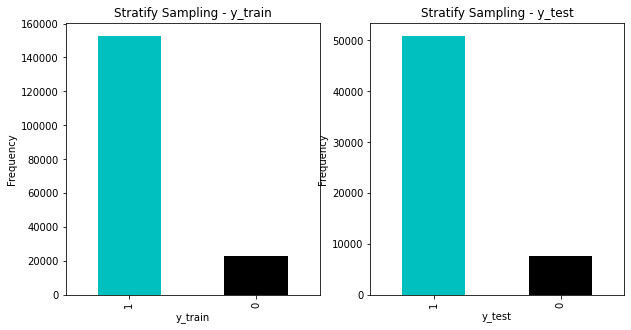

In [ ]:
plt.subplot(121)
ax = y_train.value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    title="Stratify Sampling - y_train",
                                    color=('c', 'black'))
ax.set_xlabel("y_train")
ax.set_ylabel("Frequency")
#plt.show()

plt.subplot(122)
ax = y_test.value_counts().plot(kind='bar',
                                    figsize=(10,5),
                                    title="Stratify Sampling - y_test",
                                    color=('c', 'black'))
ax.set_xlabel("y_test")
ax.set_ylabel("Frequency")
plt.show()

# <pre><font size=6>Part-2: Creating BERT Model</font> 

In [ ]:
## Loading the Pretrained Model from tensorflow HUB
tf.keras.backend.clear_session()

# maximum length of a seq in the data we have, for now i am making it as 55.
max_seq_length = 55

#BERT takes 3 inputs

#this is input words. Sequence of words represented as integers
input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")

#mask vector if you are padding anything
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")

#segment vectors. If you are giving only one sentence for the classification, total seg vector is 0. 
#If you are giving two sentenced with [sep] token separated, first seq segment vectors are zeros and 
#second seq segment vector are 1's
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")

#bert layer 
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1", trainable=False)
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

#Bert model
#We are using only pooled output not sequence out. 
#If you want to know about those, please read https://www.kaggle.com/questions-and-answers/86510
bert_model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=pooled_output)


In [ ]:
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 55)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 55)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 55)]         0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 55, 768)]                 'input_mask[0][0]',         

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

# <pre><font size=6>Part-3: Tokenization</font></pre>

In [ ]:
#getting Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

### **Getting AttributeError while using tokenizer with tensorflow >2 , lets downgrade the tensorflow and reverse it after tokenization**

***AttributeError:*** *module 'tensorflow' has no attribute 'gfile'*

In [ ]:
!pip install tensorflow==1.15.0
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
tf.enable_eager_execution()

In [ ]:
#import tokenization - We have given tokenization.py file

In [ ]:
!pip install sentencepiece 
!python3 "/content/drive/MyDrive/28 NLP with Transfer Learning/tokenization.py"

     |████████████████████████████████| 1.2 MB 8.7 MB/s 


In [ ]:
!pip install bert-tensorflow==1.0.1
import bert
from bert import tokenization

     |████████████████████████████████| 67 kB 3.6 MB/s 


In [ ]:
# Create tokenizer " Instantiate FullTokenizer" 
# name must be "tokenizer"
# the FullTokenizer takes two parameters 1. vocab_file and 2. do_lower_case 
# we have created these in the above cell ex: FullTokenizer(vocab_file, do_lower_case)
# please check the "tokenization.py" file the complete implementation

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/tokenizer.pickle'):
  tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
#Reference: https://intellipaat.com/community/491/keras-text-preprocessing-saving-tokenizer-object-to-file-for-scoring

if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/tokenizer.pickle'):
  #saving
  with open('/content/drive/MyDrive/28 NLP with Transfer Learning/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

  #loading
  with open('/content/drive/MyDrive/28 NLP with Transfer Learning/tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
#tf.io.gfile.GFile

tensorflow.python.platform.gfile.GFile

<font size=4>Grader function 3 </font>

In [ ]:
#it has to give no error 
def grader_tokenize(tokenizer):
    out = False
    try:
        out=('[CLS]' in tokenizer.vocab) and ('[SEP]' in tokenizer.vocab)
    except:
        out = False
    assert(out==True)
    return out
grader_tokenize(tokenizer)

True

In [ ]:
# Create train and test tokens (X_train_tokens, X_test_tokens) from (X_train, X_test) using Tokenizer and 

# add '[CLS]' at start of the Tokens and '[SEP]' at the end of the tokens. 

# maximum number of tokens is 55(We already given this to BERT layer above) so shape is (None, 55)

# if it is less than 55, add '[PAD]' token else truncate the tokens length.(similar to padding)

# Based on padding, create the mask for Train and Test ( 1 for real token, 0 for '[PAD]'), 
# it will also same shape as input tokens (None, 55) save those in X_train_mask, X_test_mask

# Create a segment input for train and test. We are using only one sentence so all zeros. This shape will also (None, 55)

# type of all the above arrays should be numpy arrays

# after execution of this cell, you have to get 
# X_train_tokens, X_train_mask, X_train_segment
# X_test_tokens, X_test_mask, X_test_segment

#### Example
<img src='https://i.imgur.com/5AhhmgU.png'>

In [ ]:
def create_tokens(data:'list of strings',
                  max_seq_length:'Max length of the documents' =55) -> "":
  data_mask = []
  data_segment = []
  data_tokens_encoded = []
  token_list_updated = []

  for sent in tqdm(data):
    #Tokenization
    token = tokenizer.tokenize(sent)
    #X_train_tokens.append(token)
    #Adding Special Tokens
    diff = max_seq_length - len(token)
    if len(token) >= (max_seq_length - 2):
      token_update = token[0: (max_seq_length - 2)]
      token_update.insert(0, '[CLS]')
      token_update.insert(len(token_update), '[SEP]')
      token_list_updated.append(token_update)

      #Positional Encoding
      token_encoded = np.array(tokenizer.convert_tokens_to_ids(token_update))
      data_tokens_encoded.append(token_encoded)

      #Masking
      token_mask = np.array([1]*len(token_update))
      data_mask.append(token_mask)

      #Segment
      token_segment = np.array([0]*max_seq_length)
      data_segment.append(token_segment)

    else:

      token.insert(0, '[CLS]')
      token.insert(len(token), '[SEP]')

      #Masking
      token_mask = np.array([1]*len(token)+ [0]*(max_seq_length - len(token)))
      data_mask.append(token_mask)
      #Segment
      token_segment = np.array([0]*max_seq_length)
      data_segment.append(token_segment)

      for i in range(diff-2):
        token.append('[PAD]')
      token_list_updated.append(token)

      #Positional Encoding
      token_encoded = np.array(tokenizer.convert_tokens_to_ids(token))
      data_tokens_encoded.append(token_encoded)

  data_tokens = np.array(data_tokens_encoded)
  data_mask = np.array(data_mask)
  data_segment = np.array(data_segment)

  return data_tokens, data_mask, data_segment

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/train_data.pkl'):  
  data_training = X_train.Preprocessed_text.values.tolist()
  X_train_tokens, X_train_mask, X_train_segment = create_tokens(data_training)
  #save all your results to disk so that, no need to run all again. 
  pickle.dump((X_train, X_train_tokens, X_train_mask, X_train_segment, y_train),open('/content/drive/MyDrive/28 NLP with Transfer Learning/train_data.pkl','wb'))
else:
  #you can load from disk
  X_train, X_train_tokens, X_train_mask, X_train_segment, y_train = pickle.load(open("/content/drive/MyDrive/28 NLP with Transfer Learning/train_data.pkl", 'rb')) 
  


In [ ]:
if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/val_data.pkl'):
  data_test = X_test.Preprocessed_text.values.tolist()
  X_test_tokens, X_test_mask, X_test_segment = create_tokens(data_test)
  #save all your results to disk so that, no need to run all again.
  pickle.dump((X_test, X_test_tokens, X_test_mask, X_test_segment, y_test),open('/content/drive/MyDrive/28 NLP with Transfer Learning/val_data.pkl','wb'))
else:
  X_test, X_test_tokens, X_test_mask, X_test_segment, y_test = pickle.load(open("/content/drive/MyDrive/28 NLP with Transfer Learning/val_data.pkl", 'rb')) 


<font size=4>Grader function 4 </font>

In [ ]:
max_seq_length = 55

In [ ]:
def grader_alltokens_train():
    out = False
    
    if type(X_train_tokens) == np.ndarray:
        
        temp_shapes = (X_train_tokens.shape[1]==max_seq_length) and (X_train_mask.shape[1]==max_seq_length) and \
        (X_train_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_train_segment)
        
        mask_temp = np.sum(X_train_mask==0) == np.sum(X_train_tokens==0)
        
        no_cls = np.sum(X_train_tokens==tokenizer.vocab['[CLS]'])==X_train_tokens.shape[0]
        
        no_sep = np.sum(X_train_tokens==tokenizer.vocab['[SEP]'])==X_train_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out

grader_alltokens_train()

True

<font size=4>Grader function 5 </font>

In [ ]:
def grader_alltokens_test():
    out = False
    if type(X_test_tokens) == np.ndarray:
        
        temp_shapes = (X_test_tokens.shape[1]==max_seq_length) and (X_test_mask.shape[1]==max_seq_length) and \
        (X_test_segment.shape[1]==max_seq_length)
        
        segment_temp = not np.any(X_test_segment)
        
        mask_temp = np.sum(X_test_mask==0) == np.sum(X_test_tokens==0)
        
        no_cls = np.sum(X_test_tokens==tokenizer.vocab['[CLS]'])==X_test_tokens.shape[0]
        
        no_sep = np.sum(X_test_tokens==tokenizer.vocab['[SEP]'])==X_test_tokens.shape[0]
        
        out = temp_shapes and segment_temp and mask_temp and no_cls and no_sep
      
    else:
        print('Type of all above token arrays should be numpy array not list')
        out = False
    assert(out==True)
    return out
grader_alltokens_test()

True

**Updating back Tensorflow to latest**

In [ ]:
!pip install --upgrade tensorflow

# <pre><font size=6>Part-4: Getting Embeddings from BERT Model</font>

<pre><font size=3>Part-4: Getting Embeddings from BERT Model</font>
We already created the BERT model in the part-2 and input data in the part-3. 
We will utlize those two and will get the embeddings for each sentence in the 
Train and test data.</pre>

In [ ]:
bert_model.input

[<KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_word_ids')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'input_mask')>,
 <KerasTensor: shape=(None, 55) dtype=int32 (created by layer 'segment_ids')>]

In [ ]:
bert_model.output

<KerasTensor: shape=(None, 768) dtype=float32 (created by layer 'keras_layer')>

In [ ]:
if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/final_output.pkl'):
  # get the train output, BERT model will give one output so save in
  # X_train_pooled_output
  X_train_pooled_output=bert_model.predict([X_train_tokens,X_train_mask,X_train_segment])

  # get the test output, BERT model will give one output so save in
  # X_test_pooled_output
  X_test_pooled_output=bert_model.predict([X_test_tokens,X_test_mask,X_test_segment])

  #save all your results to disk so that, no need to run all again. 
  pickle.dump((X_train_pooled_output, X_test_pooled_output),open('/content/drive/MyDrive/28 NLP with Transfer Learning/final_output.pkl','wb'))

else:
  X_train_pooled_output, X_test_pooled_output= pickle.load(open('/content/drive/MyDrive/28 NLP with Transfer Learning/final_output.pkl', 'rb'))


<font size=4>Grader function 6 </font>

In [ ]:
#now we have X_train_pooled_output, y_train
#X_test_pooled_ouput, y_test

#please use this grader to evaluate
def greader_output():
    assert(X_train_pooled_output.shape[1]==768)
    assert(len(y_train)==len(X_train_pooled_output))
    assert(X_test_pooled_output.shape[1]==768)
    assert(len(y_test)==len(X_test_pooled_output))
    assert(len(y_train.shape)==1)
    assert(len(X_train_pooled_output.shape)==2)
    assert(len(y_test.shape)==1)
    assert(len(X_test_pooled_output.shape)==2)
    return True
greader_output()

True

In [ ]:
pd.DataFrame(X_test_pooled_output)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,728,729,730,731,732,733,734,735,736,737,738,739,740,741,742,743,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767
0,-0.258312,-0.321092,-0.912870,0.308989,0.648930,-0.024759,-0.036962,0.058018,-0.594797,-0.998984,-0.061828,0.691426,0.912094,0.575230,0.521010,-0.049975,0.507383,-0.392888,0.115432,0.802938,0.340000,0.999935,0.116707,0.262389,0.262198,0.732423,-0.215783,0.769269,0.750331,0.613294,0.011565,0.103016,-0.962504,-0.060865,-0.876117,-0.936996,0.176257,-0.290398,0.121105,0.187344,...,0.216378,-0.239709,-0.088886,-0.194607,0.293749,-0.489693,-0.410097,-0.306165,0.316548,0.072115,0.999921,-0.730767,-0.712495,-0.267652,-0.386685,0.336257,-0.173107,-1.0,0.107878,-0.450998,0.778396,-0.404878,0.833108,-0.302055,-0.688388,-0.223286,0.620838,0.701133,-0.343996,0.114309,0.528653,0.071158,0.813151,0.466559,0.349496,-0.044911,0.620475,-0.796169,-0.500018,0.671502
1,-0.842307,-0.452401,-0.944674,0.745324,0.878278,-0.259758,0.687058,0.161834,-0.870230,-0.999927,-0.608795,0.979009,0.967588,0.506843,0.919345,-0.643190,-0.097134,-0.643508,0.298079,0.387908,0.747423,0.999997,-0.080728,0.376494,0.454627,0.993258,-0.672916,0.927688,0.930455,0.708073,-0.359010,0.217823,-0.987663,-0.070491,-0.943001,-0.985140,0.412089,-0.654999,0.002828,0.202188,...,0.123703,-0.345646,-0.348825,-0.550891,0.766931,-0.771195,-0.530927,-0.530363,0.756707,0.330745,0.999996,-0.866028,-0.937247,-0.588924,-0.445193,0.445565,-0.588475,-1.0,0.341096,-0.746372,0.771590,-0.866776,0.885410,-0.815065,-0.958911,-0.196754,0.763200,0.897372,-0.447089,-0.717114,0.670379,-0.577770,0.992854,0.798916,-0.358254,0.306078,0.763926,-0.905538,-0.661897,0.893891
2,-0.814029,-0.545592,-0.978901,0.768636,0.857545,-0.203467,0.734113,0.403831,-0.941929,-0.999986,-0.598649,0.942593,0.956420,0.782484,0.901281,-0.795851,-0.344678,-0.690637,0.401946,0.168018,0.709702,1.000000,-0.345363,0.354176,0.508652,0.994318,-0.815225,0.903774,0.922477,0.706940,-0.667559,0.286065,-0.979098,-0.364612,-0.984775,-0.984802,0.504913,-0.695238,-0.256960,0.030247,...,0.621032,-0.414968,-0.446317,-0.609928,0.775118,-0.623580,-0.748817,-0.723692,0.768974,0.411211,1.000000,-0.927264,-0.971753,-0.437773,-0.357769,0.540301,-0.649295,-1.0,0.311807,-0.571449,0.890878,-0.924201,0.918652,-0.826819,-0.973501,-0.535004,0.682303,0.878007,-0.584821,-0.853749,0.737626,-0.255405,0.992705,0.714948,-0.024003,-0.367051,0.814095,-0.922221,-0.740750,0.848743
3,-0.839950,-0.445260,-0.823857,0.734423,0.798083,-0.124350,0.533186,0.023286,-0.603242,-0.999878,-0.493363,0.946773,0.978171,0.103567,0.870635,-0.594091,-0.041267,-0.493921,0.275495,0.498961,0.628606,0.999927,0.112620,0.302348,0.366182,0.973357,-0.629451,0.892108,0.934881,0.762371,-0.154016,0.160727,-0.992557,-0.083354,-0.666690,-0.987752,0.361493,-0.629215,0.125046,0.173302,...,0.153305,-0.404850,-0.263938,-0.650295,0.690242,-0.783878,-0.555466,-0.434066,0.695513,0.283794,0.999937,-0.573477,-0.858972,-0.628948,-0.324190,0.399221,-0.513667,-1.0,0.277669,-0.536104,0.460873,-0.666995,0.760082,-0.744192,-0.913457,-0.181177,0.732918,0.745400,-0.441848,-0.774313,0.457396,-0.631007,0.966280,0.809260,-0.070077,0.592089,0.556625,-0.785270,-0.662402,0.866694
4,-0.887289,-0.503260,-0.945019,0.853797,0.738072,-0.150253,0.936541,0.338978,-0.895424,-0.999993,-0.623827,0.963739,0.971523,0.657209,0.941938,-0.823816,-0.291251,-0.648280,0.380536,-0.491619,0.759814,0.999997,0.015122,0.416629,0.507493,0.992908,-0.762082,0.947566,0.963068,0.714920,-0.775785,0.301830,-0.986941,-0.288538,-0.917148,-0.994289,0.504424,-0.762501,-0.130997,-0.076945,...,0.254080,-0.494280,-0.457338,-0.599396,0.890196,-0.541665,-0.662635,-0.641065,0.764694,0.416270,0.999997,-0.839768,-0.947081,-0.283536,-0.543385,0.526285,-0.524696,-1.0,0.407760,-0.692607,0.806685,-0.780773,0.885491,-0.725603,-0.987382,-0.305246,0.474194,0.807178,-0.588387,-0.569625,0.788943,-

# <pre><font size=6>Part-5: Training a NN with 768 features</font>

In [ ]:
##imports
import tensorflow
import tensorboard
%load_ext tensorboard
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Input, Dense, Activation, Conv1D
from tensorflow.keras.layers import  Dropout, Flatten, Reshape, BatchNormalization, MaxPooling1D

### **5.1 Callbacks**

In [ ]:
#Reference:https://stackoverflow.com/questions/59666138/sklearn-roc-auc-score-with-multi-class-ovr-should-have-none-average-available
#Code Reference: https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
#Reference:https://learning.oreilly.com/library/view/deep-learning-quick/9781788837996/a22485be-e397-4b46-86b2-29b7878953f5.xhtml#:~:text=Let's%20use%20one%20more%20callback,Keras%20is%20actually%20really%20simple.

from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau

class RocCallback(Callback):
    def __init__(self,training_data,validation_data):
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]


    def on_epoch_end(self, epoch, logs={}):
     
        y_pred_train = np.argmax(model.predict(self.x),axis=1)
        roc_train = roc_auc_score(self.y, y_pred_train, average='weighted', multi_class='ovr')

        y_pred_val = np.argmax(model.predict(self.x_val),axis=1)
        roc_val = roc_auc_score(self.y_val, y_pred_val, average='weighted', multi_class='ovr')
        print('ROC-AUC Train: %s - ROC-AUC Test: %s' % (str(round(roc_train,4)),str(round(roc_val,4))),end=100*' '+'\n')
        return

ROC_AUC = RocCallback(training_data=(X_train_pooled_output, y_train),
                  validation_data=(X_test_pooled_output, y_test))

#Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="/content/drive/MyDrive/26 RNN LSTM /log/model", histogram_freq=1)

#Learning Rate
#https://stackoverflow.com/questions/39779710/setting-up-a-learningratescheduler-in-keras
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
def scheduler(epoch, lr):
  if epoch % 10 ==0:
    return lr*0.95
  else:
    return lr
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

#Early Stop
earlystop = EarlyStopping(monitor='accuracy', patience=50, verbose=1)

#Reduce on Plateau
decay_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.9, patience=10, 
                                                verbose=0, mode='auto', min_delta=0.001, 
                                                cooldown=0, min_lr=1e-6)


#callback_list = [lr_scheduler, decay_lr, checkpoint, tensorboard_callback]

In [ ]:
#Reference:https://www.codegrepper.com/code-examples/python/auc+callback+keras

#import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auroc(y_true, y_pred):
    return tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)

### **5.2 Importing various optimizers for experiment:**

In [ ]:
import tensorflow as tf
optimizer_SGD = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.8, nesterov=True, 
    name='SGD')

optimizer_aadam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

optimizer_adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07,
    name='Adamax')

optimizer_RMSprop = tf.keras.optimizers.RMSprop(
    learning_rate=0.01, rho=0.9, momentum=0.8, epsilon=1e-07, centered=False,
    name='RMSprop')

optimizer_adagrad = tf.keras.optimizers.Adagrad(
    learning_rate=0.1, initial_accumulator_value=0.1, epsilon=1e-07,
    name='Adagrad')

optimizer_adadelta = tf.keras.optimizers.Adadelta(
    learning_rate=0.1, rho=0.95, epsilon=1e-07, name='Adadelta')

### **5.3 Function for Plotting Loss and AUC:**

In [ ]:
#Reference:https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
# plot diagnostic learning curves
import matplotlib.pyplot as plt
def summarize_diagnostics(history):
  #plot Loss
  plt.figure(figsize=(10,10))
  plt.subplot(211)
  plt.title('Cross Entropy Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='test')
  plt.xlabel("Epochs")

  # plot accuracy
  plt.subplot(212)
  plt.title('Classification AUC')
  plt.plot(history.history['auroc'], color='blue', label='train')
  plt.plot(history.history['val_auroc'], color='orange', label='test')
  plt.xlabel("Epochs")

  plt.show()

### **5.4 Models Architecture**

In [ ]:
X_in = Input(shape=(X_train_pooled_output[0].shape))
X_in_reshaped = Reshape((768,1))(X_in)

X_conv1d_O = Conv1D(filters=132, kernel_size=16, activation='relu')(X_in_reshaped)


#Adding Batch Normalization and Dropout Layers
X_normalized_1 = BatchNormalization()(X_conv1d_O)
X_dropout_1 = Dropout((0.2))(X_normalized_1)

X_maxpooled_1 = MaxPooling1D(pool_size=2, strides=2, padding='same')(X_dropout_1)

X_conv1d_I = Conv1D(filters=64, kernel_size=12, activation='tanh')(X_maxpooled_1)


#Adding Batch Normalization and Dropout Layers
X_normalized_2 = BatchNormalization()(X_conv1d_I)
X_dropout_2 = Dropout((0.5))(X_normalized_2)

X_maxpooled_2 = MaxPooling1D(pool_size=2, strides=2, padding='valid')(X_dropout_2)

X_dropout_3 = Dropout((0.2))(X_maxpooled_2)
X_conv1d_1 = Conv1D(filters=32, kernel_size=8, activation='relu')(X_dropout_3)
X_conv1d_2 = Conv1D(filters=16, kernel_size=4, activation='relu')(X_conv1d_1)
X_flatten = Flatten()(X_conv1d_2)
X_dropout = Dropout((0.2))(X_flatten)

X_dense_1 = Dense(128, activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(X_dropout)
X_normalized_3 = BatchNormalization()(X_dense_1)
X_dropout_3 = Dropout((0.5))(X_normalized_3)

X_dense_2 = Dense(32, activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(X_dropout_3)
X_normalized_4 = BatchNormalization()(X_dense_2)

X_dense_3 = Dense(16, activation='relu',kernel_initializer=tf.keras.initializers.glorot_normal(seed=30))(X_normalized_4)


X_out = Dense(2, activation='softmax', kernel_initializer=tf.keras.initializers.glorot_normal(seed=30) )(X_dense_3)

model = Model(inputs=X_in, outputs=X_out)

print(model.summary())



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 reshape (Reshape)           (None, 768, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 753, 132)          2244      
                                                                 
 batch_normalization (BatchN  (None, 753, 132)         528       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 753, 132)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 377, 132)         0         
 )                                                         

In [ ]:
#Saving Best Model and Representation of results
filepath = "/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5"
checkpoint = ModelCheckpoint(filepath= filepath, save_weights_only=True,
                              monitor='val_auroc', verbose=1,
                              save_best_only=True, mode='max') 

log_dir = "logs/model_1"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq=1)
callback_list = [checkpoint, tensorboard_callback, decay_lr]



optimizer_adagrad = tf.keras.optimizers.Adagrad(
    learning_rate=0.000001 , initial_accumulator_value=0.1, epsilon=1e-07,
    name='Adagrad')

callback_list = [tensorboard_callback, checkpoint]

optimizer_aadam = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')

#Model Compilation
model.compile(optimizer=optimizer_aadam, loss='categorical_crossentropy', metrics=['accuracy', auroc])

In [ ]:
epochs = 100

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_100Epoch.h5')

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.0001)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_100Epoch.h5')

epochs = 100

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_200poch.h5')

Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 0.4819 - accuracy: 0.8364 - auroc: 0.5064
Epoch 00001: val_auroc improved from 0.55970 to 0.55981, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 136ms/step - loss: 0.4819 - accuracy: 0.8364 - auroc: 0.5064 - val_loss: 0.4195 - val_accuracy: 0.8706 - val_auroc: 0.5598
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 0.4799 - accuracy: 0.8377 - auroc: 0.5078
Epoch 00002: val_auroc improved from 0.55981 to 0.55990, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 135ms/step - loss: 0.4799 - accuracy: 0.8377 - auroc: 0.5078 - val_loss: 0.4196 - val_accuracy: 0.8706 - val_auroc: 0.5599
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8369 - auroc: 0.5071
Epoch 00003

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.00001)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_200poch.h5')

epochs = 100

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_300poch.h5')

Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.8421 - auroc: 0.5094
Epoch 00001: val_auroc improved from 0.56925 to 0.56933, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 137ms/step - loss: 0.4766 - accuracy: 0.8421 - auroc: 0.5094 - val_loss: 0.4185 - val_accuracy: 0.8706 - val_auroc: 0.5693
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 0.4780 - accuracy: 0.8416 - auroc: 0.5081
Epoch 00002: val_auroc improved from 0.56933 to 0.56943, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 135ms/step - loss: 0.4780 - accuracy: 0.8416 - auroc: 0.5081 - val_loss: 0.4184 - val_accuracy: 0.8706 - val_auroc: 0.5694
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 0.4781 - accuracy: 0.8420 - auroc: 0.5064
Epoch 00003

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.000001)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_300poch.h5')

epochs = 100

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_400poch.h5')

Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 0.4777 - accuracy: 0.8447 - auroc: 0.5048
Epoch 00001: val_auroc improved from 0.57719 to 0.57728, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 137ms/step - loss: 0.4777 - accuracy: 0.8447 - auroc: 0.5048 - val_loss: 0.4147 - val_accuracy: 0.8706 - val_auroc: 0.5773
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 0.4766 - accuracy: 0.8447 - auroc: 0.5049
Epoch 00002: val_auroc improved from 0.57728 to 0.57735, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 135ms/step - loss: 0.4766 - accuracy: 0.8447 - auroc: 0.5049 - val_loss: 0.4146 - val_accuracy: 0.8706 - val_auroc: 0.5773
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.8450 - auroc: 0.5090
Epoch 00003

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.0000001)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_400poch.h5')

epochs = 100

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_500poch.h5')

Epoch 1/100
176/176 [==============================] - ETA: 0s - loss: 0.4719 - accuracy: 0.8471 - auroc: 0.5109
Epoch 00001: val_auroc improved from 0.58440 to 0.58447, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 136ms/step - loss: 0.4719 - accuracy: 0.8471 - auroc: 0.5109 - val_loss: 0.4108 - val_accuracy: 0.8706 - val_auroc: 0.5845
Epoch 2/100
176/176 [==============================] - ETA: 0s - loss: 0.4730 - accuracy: 0.8470 - auroc: 0.5091
Epoch 00002: val_auroc improved from 0.58447 to 0.58455, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best.hdf5
176/176 [==============================] - 24s 135ms/step - loss: 0.4730 - accuracy: 0.8470 - auroc: 0.5091 - val_loss: 0.4108 - val_accuracy: 0.8706 - val_auroc: 0.5845
Epoch 3/100
176/176 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8464 - auroc: 0.5091
Epoch 00003

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.005)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_500poch.h5')

epochs = 10

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_510poch.h5')

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8628 - auroc: 0.6043
Epoch 00001: val_auroc did not improve from 0.52364
176/176 [==============================] - 24s 138ms/step - loss: 0.3900 - accuracy: 0.8628 - auroc: 0.6043 - val_loss: 0.7603 - val_accuracy: 0.8706 - val_auroc: 0.2141
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 0.3270 - accuracy: 0.8714 - auroc: 0.7767
Epoch 00002: val_auroc improved from 0.52364 to 0.61161, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5
176/176 [==============================] - 24s 139ms/step - loss: 0.3270 - accuracy: 0.8714 - auroc: 0.7767 - val_loss: 0.8793 - val_accuracy: 0.8706 - val_auroc: 0.6116
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 0.2931 - accuracy: 0.8783 - auroc: 0.8381
Epoch 00003: val_auroc improved from 0.61161 to 0.89247, saving model to /content/drive/MyDrive/28 NLP with Transfe

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.005)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5')

epochs = 10

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_520poch.h5')

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 0.2328 - accuracy: 0.9023 - auroc: 0.9096
Epoch 00001: val_auroc improved from 0.92988 to 0.93406, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5
176/176 [==============================] - 25s 139ms/step - loss: 0.2328 - accuracy: 0.9023 - auroc: 0.9096 - val_loss: 0.2034 - val_accuracy: 0.9152 - val_auroc: 0.9341
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 0.2308 - accuracy: 0.9040 - auroc: 0.9118
Epoch 00002: val_auroc improved from 0.93406 to 0.93530, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5
176/176 [==============================] - 25s 139ms/step - loss: 0.2308 - accuracy: 0.9040 - auroc: 0.9118 - val_loss: 0.2074 - val_accuracy: 0.9161 - val_auroc: 0.9353
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 0.2267 - accuracy: 0.9050 - auroc: 0.9150
Epoch 0000

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.005)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5')

epochs = 10

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_530poch.h5')

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 0.2130 - accuracy: 0.9115 - auroc: 0.9262
Epoch 00001: val_auroc did not improve from 0.94379
176/176 [==============================] - 25s 139ms/step - loss: 0.2130 - accuracy: 0.9115 - auroc: 0.9262 - val_loss: 0.2209 - val_accuracy: 0.9156 - val_auroc: 0.9406
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 0.2116 - accuracy: 0.9127 - auroc: 0.9271
Epoch 00002: val_auroc did not improve from 0.94379
176/176 [==============================] - 24s 138ms/step - loss: 0.2116 - accuracy: 0.9127 - auroc: 0.9271 - val_loss: 0.2009 - val_accuracy: 0.9212 - val_auroc: 0.9435
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 0.2112 - accuracy: 0.9134 - auroc: 0.9274
Epoch 00003: val_auroc did not improve from 0.94379
176/176 [==============================] - 24s 138ms/step - loss: 0.2112 - accuracy: 0.9134 - auroc: 0.9274 - val_loss: 0.2028 - val_accuracy: 0.9196 - val_auroc: 0.943

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.001)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5')

epochs = 10

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_540poch.h5')

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 0.2594 - accuracy: 0.8911 - auroc: 0.8820
Epoch 00001: val_auroc did not improve from 0.94676
176/176 [==============================] - 24s 139ms/step - loss: 0.2594 - accuracy: 0.8911 - auroc: 0.8820 - val_loss: 0.2169 - val_accuracy: 0.9140 - val_auroc: 0.9298
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9008 - auroc: 0.9045
Epoch 00002: val_auroc did not improve from 0.94676
176/176 [==============================] - 24s 138ms/step - loss: 0.2379 - accuracy: 0.9008 - auroc: 0.9045 - val_loss: 0.2073 - val_accuracy: 0.9164 - val_auroc: 0.9339
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 0.2291 - accuracy: 0.9049 - auroc: 0.9126
Epoch 00003: val_auroc did not improve from 0.94676
176/176 [==============================] - 24s 138ms/step - loss: 0.2291 - accuracy: 0.9049 - auroc: 0.9126 - val_loss: 0.2029 - val_accuracy: 0.9188 - val_auroc: 0.938

In [ ]:
import tensorflow.keras.backend as k
k.set_value(model.optimizer.lr, 0.001)

model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5')

epochs = 10

#Training the model
history = model.fit(X_train_pooled_output, y_train_cat, validation_data=(X_test_pooled_output, y_test_cat), 
           batch_size=1000, epochs=epochs, verbose='auto', callbacks = callback_list)


model.save_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_550poch.h5')

Epoch 1/10
176/176 [==============================] - ETA: 0s - loss: 0.2059 - accuracy: 0.9144 - auroc: 0.9316
Epoch 00001: val_auroc did not improve from 0.94732
176/176 [==============================] - 24s 138ms/step - loss: 0.2059 - accuracy: 0.9144 - auroc: 0.9316 - val_loss: 0.1967 - val_accuracy: 0.9228 - val_auroc: 0.9469
Epoch 2/10
176/176 [==============================] - ETA: 0s - loss: 0.2049 - accuracy: 0.9151 - auroc: 0.9324
Epoch 00002: val_auroc improved from 0.94732 to 0.94771, saving model to /content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5
176/176 [==============================] - 24s 137ms/step - loss: 0.2049 - accuracy: 0.9151 - auroc: 0.9324 - val_loss: 0.1908 - val_accuracy: 0.9242 - val_auroc: 0.9477
Epoch 3/10
176/176 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9157 - auroc: 0.9322
Epoch 00003: val_auroc improved from 0.94771 to 0.94852, saving model to /content/drive/MyDrive/28 NLP with Transfe

In [ ]:
#Saving Entire the model for future use:
model.save('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_final', save_traces=True)


#Loading Model Archtecture
final_model = models.load_model('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_final', custom_objects={'auroc':auroc})

#Loading Weights from best model
final_model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5')


In [ ]:
#Loading Best Model
model.load_weights('/content/drive/MyDrive/28 NLP with Transfer Learning/Model Output/model_best_1.hdf5')

In [1]:
#y_pred_test= np.argmax(model.predict(X_test_pooled_output), axis=1)
#print(list(y_pred_test))

In [2]:
#print(list(y_test))

In [ ]:
from prettytable import PrettyTable


x = PrettyTable()
x.field_names = ["Model", "#Epoch","Model Description","Train AUC", "Test AUC"]
x.add_row(["Model_best_1 ",550,"Conv + Dense ", 0.9374 , 0.9504])


print(x)

+---------------+--------+-------------------+-----------+----------+
|     Model     | #Epoch | Model Description | Train AUC | Test AUC |
+---------------+--------+-------------------+-----------+----------+
| Model_best_1  |  550   |   Conv + Dense    |   0.9374  |  0.9504  |
+---------------+--------+-------------------+-----------+----------+


# <Pre><font size=6>Part-6: Creating a Data pipeline for BERT Model</font> 

<Pre><font size=3>Part-6: Creating a Data pipeline for BERT Model</font> 

1. Download data 
2. Read the csv file
3. Remove all the html tags
4. Now do tokenization [Part 3 as mentioned above]
    * Create tokens,mask array and segment array
5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   * Print the shape of output(X_test.shape).You should get (352,768)
6. Predit the output of X_test with the Neural network model which we trained earlier.
7. Print the occurences of class labels in the predicted output

</pre>

In [ ]:
#1. Download data from here
#2. Read the csv file
data = pd.read_csv("/content/drive/MyDrive/28 NLP with Transfer Learning/test.csv")

#3. Remove all the html tags
data = data.Text.apply(remove_html).to_list()

#4. Now do tokenization [Part 3 as mentioned above]
    #* Create tokens,mask array and segment array
#5. Get Embeddings from BERT Model [Part 4 as mentioned above] , let it be X_test
   #* Print the shape of output(X_test.shape).You should get (352,768)
if not os.path.isfile('/content/drive/MyDrive/28 NLP with Transfer Learning/test_data.pkl'):
  test_tokens, test_mask, test_segment = create_tokens(data, max_seq_length=55) 
  Test_pooled_output = bert_model.predict([test_tokens,test_mask,test_segment])
  pickle.dump((test_tokens, test_mask, test_segment, Test_pooled_output),open('/content/drive/MyDrive/28 NLP with Transfer Learning/test_data.pkl','wb'))
else:
  test_tokens, test_mask, test_segment, Test_pooled_output = pickle.load(open("/content/drive/MyDrive/28 NLP with Transfer Learning/test_data.pkl", 'rb')) 
print("The output shape is : {0} .".format(Test_pooled_output.shape))
print("--"*25)

#6. Predit the output of X_test with the Neural network model which we trained earlier.
test_predict_prob = model.predict(Test_pooled_output)
test_class_pred = test_predict_prob.argmax(axis=-1)

#7. Print the occurences of class labels in the predicted output
print("Predicted Class Labels Are :\n \n {0} ".format(test_class_pred))
print("--"*25)

print("\n Class Labels Occurances: \n 0 - {0} times \n 1 - {1} times ".format(np.bincount(test_class_pred)[0], np.bincount(test_class_pred)[1] ))

The output shape is : (352, 768) .
--------------------------------------------------
Predicted Class Labels Are :
 
 [0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 1 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1] 
--------------------------------------------------

 Class Labels Occurances: 
 0 - 65 times 
 1 - 287 times 


END◼